In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import camb
from camb import model, initialpower
import pandas as pd
import re

In [2]:
omega_nu = np.array([0.0006356, 0.002, 0.006356])
# Add corresponding file accessors, to check our work later
pnu_omegas = np.array(["0.0006", "0.002", "0.006"])
omega_index = 1 # while we debug, we confine our attention to just one value

In [3]:
# Keep in mind that this is NOT the same file as the original "cosmology_Aletheia.dat"
# that Ariel gave us! If you use the unaltered version, you will get a segfault.
cosm = pd.read_csv("cosmologies.dat", sep='\s+')

# We simulate at redshifts determined by columns that contain the letter z
redshift_column = re.compile("z.+")

In [4]:
def parse_redshifts(model_num):
    """
    Return the list of amplitude-equalized redshifts
    given for a particular model in the Aletheia dat file.
    
    This function is intended to return the redshifts
    in order from high (old) to low (recent),
    which is the order that CAMB will impose
    if not already used.
    """
    z = []
    model = cosm.loc[model_num]
    
    for column in cosm.columns:
        if redshift_column.match(column):
            z.append(model[column])
            
    # No need to sort these because they should already
    # be in descending order.
    return np.array(z)

In [5]:
def kzps(mlc, omnuh2_in, massive_neutrinos=False, sigma12_in=1, zs = [0]):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model.
    @param mlc : "MassLess Cosmology"
        a dictionary of values
        for CAMBparams fields
    @param omnuh2_in : neutrino physical mass density
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the desired sigma12 of the model
    @massive_neutrinos : if this is True,
        the value in omnuh2_in is used to set omnuh2.
        If this is False,
        the value in omnuh2_in is simply added to omch2.
    """ 
    pars = camb.CAMBparams()
    omch2_in = mlc["omch2"]
    
    mnu_in = 0
    nnu_massive = 0
    
    if massive_neutrinos:
        '''
        This is a horrible workaround, and I would like to get rid of it ASAP
        The following line destroys dependence on TCMB and neutrino_hierarchy,
        possibly more. But CAMB does not accept omnuh2 as an input, so I have
        to reverse-engineer it somehow.
        
        Also, should we replace default_nnu with something else in the
        following expression? Even if we're changing N_massive to 1,
        N_total_eff = 3.046 nonetheless, right?
        '''
        mnu_in = omnuh2_in * camb.constants.neutrino_mass_fac / \
            (camb.constants.default_nnu / 3.0) ** 0.75 
        
        omch2_in -= omnuh2_in
        nnu_massive = 1 
        
    pars.set_cosmology(
        H0=mlc["h"] * 100,
        ombh2=mlc["ombh2"],
        omch2=omch2_in,
        omk=mlc["OmK"],
        mnu=mnu_in,
        num_massive_neutrinos=nnu_massive,
        neutrino_hierarchy="degenerate" # 1 eigenstate approximation;
        # our neutrino setup (see below) is not valid for inverted/normal hierarchies.
    )
    
    pars.num_nu_massless = 3.046 - nnu_massive
    pars.nu_mass_eigenstates = nnu_massive
    pars.nu_mass_numbers[:(pars.nu_mass_eigenstates + 1)] = \
        list(np.ones(len(pars.nu_mass_numbers[:(pars.nu_mass_eigenstates + 1)]), int))
    pars.num_nu_massive = 0
    if nnu_massive != 0:
        pars.num_nu_massive = sum(pars.nu_mass_numbers[:(pars.nu_mass_eigenstates + 1)])
    
    pars.InitPower.set_params(As=mlc["A_s"], ns=mlc["n_s"])
    pars.set_dark_energy(w=mlc["w0"], wa=float(mlc["wa"]), dark_energy_model='ppf')
    
    '''
    To change the the extent of the k-axis,
    change the following line as well as the "get_matter_power_spectrum" call
    
    In some cursory tests, the accurate_massive_neutrino_transfers
    flag did not appear to significantly alter the outcome.
    '''
    pars.set_matter_power(redshifts=zs, kmax=10.0, nonlinear=False)
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)

    # The flags var1=8 and var2=8 indicate that we are looking at the
    # power spectrum of CDM + baryons (i.e. neutrinos excluded).
    k, z, p = results.get_matter_power_spectrum(
        minkh=1e-4, maxkh=10.0, npoints = 10000,
        var1=8, var2=8
    )
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    
    return k, z, p, sigma12

In [6]:
k_massless_list = []
z_massless_list = []
p_massless_list = []
s12_massless_list = []

k_massive_list = []
z_massive_list = []
p_massive_list = []
s12_massive_list = []

for index, row in cosm.iterrows():
    if index > 1:
        # I don't yet understand how to implement the last model; skip
        continue
    
    z_in = parse_redshifts(index)
    k, z, p, s12 = kzps(row, omega_nu[omega_index], massive_neutrinos=False,
                       zs=z_in)
    k_massless_list.append(k)
    z_massless_list.append(z)
    p_massless_list.append(p)
    s12_massless_list.append(s12)
    
    k, z, p, s12 = kzps(row, omega_nu[omega_index], massive_neutrinos=True,
                       zs=z_in)
    k_massive_list.append(k)
    z_massive_list.append(z)
    p_massive_list.append(p)
    s12_massive_list.append(s12)

In [7]:
colors = ["green", "blue", "brown", "red", "black", "orange", "purple", "magenta"]
#styles = ["solid", "dotted", "dashed", "dashdot", "solid", "dotted", "dashed", "dashdot"]
# Line styles are unfortunately too distracting in so dense a plot; make everything solid
styles = ["solid"] * 8

In [8]:
def truncator(big_x, big_y, small_x, small_y, interpolation=True):
    """
    Truncate big arrays based on small_arrays,
    then interpolate the small arrays over
    the truncated big_x domain.
    @returns:
        trunc_x: truncated big_x array
        trunc_y: truncated big_y array
        aligned_y: interpolation of small_y over trunc_x
    """
    # What is the most conservative lower bound?
    lcd_min = max(min(small_x), min(big_x))
    # What is the most conservative upper bound?
    lcd_max = min(max(small_x), max(big_x))
    
    # Eliminate points outside the conservative bounds
    mask = np.all([[big_x < lcd_max], [big_x > lcd_min]], axis=0)[0]
    trunc_x = big_x[mask]
    trunc_y = big_y[mask]
    
    aligned_y = small_y[mask]
    # Is the spacing different in big_x and small_x?
    if interpolation:
        interpolator = interp1d(small_x, small_y, kind="cubic")
        aligned_y = interpolator(trunc_x)
    
    return trunc_x, trunc_y, aligned_y

In [9]:
baseline = pd.read_csv("power_nu/Aletheia_powernu_zorig_nu" + \
                       pnu_omegas[omega_index] + "_caso0_0000.dat",
                       names=["k", "P_no", "P_nu", "ratio"], sep='\s+')
baseline_max = pd.read_csv("power_nu/Aletheia_powernu_zorig_nu" + \
                        pnu_omegas[omega_index] + "_caso0_0004.dat",
                       names=["k", "P_no", "P_nu", "ratio"], sep='\s+')

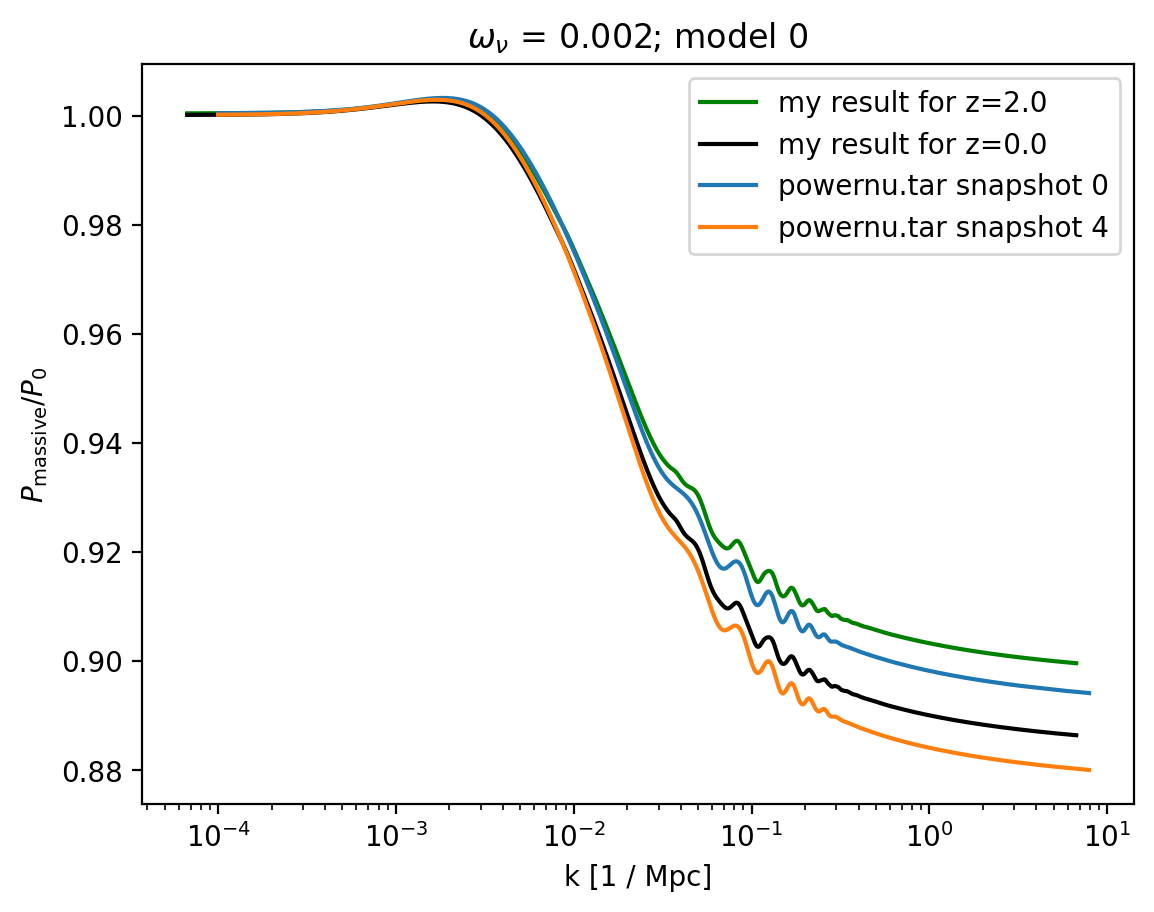

In [10]:
# Let's just look at model 0 for the initial comparisons
i = 0
# Let's just look at redshift 0 for the initial comparisons
j = 4

h = cosm.loc[i]["h"]
plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
             label="my result for z=" + str(z_massive_list[i][j]), c=colors[i])
j = 0 # This will correspond to z=2 for the model0 case.
plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
             label="my result for z="  + str(z_massive_list[i][j]), c="black")
plt.plot(baseline["k"], baseline["ratio"], label="powernu.tar snapshot 0")
plt.plot(baseline_max["k"], baseline_max["ratio"], label="powernu.tar snapshot 4")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]) + "; model 0")
plt.legend()

In [15]:
m0 = cosm.loc[0]

def omnu_tester(omega_nu_in):
    z_in = np.array([0])
    ko, zo, po, s12o = kzps(m0, omega_nu_in, massive_neutrinos=False,
                       zs=z_in)
    km, zm, pm, s12m = kzps(m0, omega_nu_in, massive_neutrinos=True,
                       zs=z_in)    
    return ko, po, km, pm

def guess(omega_nu_in):
    # Let's just look at model 0 for the initial comparisons
    i = 0
    # Let's just look at redshift 0 for the initial comparisons
    j = 4

    kto, pto, km, ptm = omnu_tester(omega_nu_in)
    h = cosm.loc[0]["h"]
    plt.plot(kto * h, ptm[0] / pto[0],
                 label="my result for z=0", c=colors[i])
    plt.plot(baseline_max["k"], baseline_max["ratio"], label="powernu.tar snapshot 4")
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]) + "; model 0")
    plt.legend()

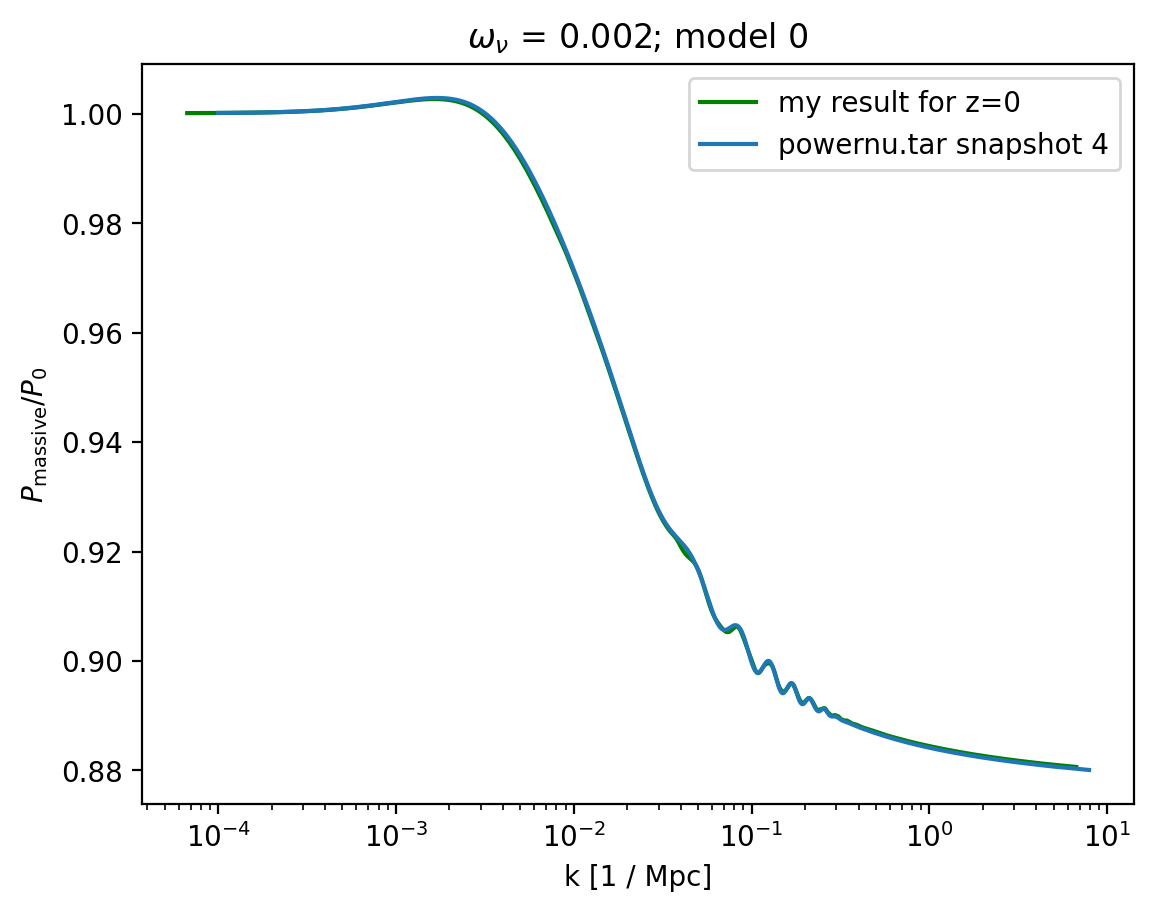

In [22]:
guess(0.0021)